# Intro

In [1]:
# Data
import os
import numpy as np
import pandas as pd

# SkLearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR

# Display
from IPython.display import clear_output

# Visualizaciones
import matplotlib.pyplot as plt
import seaborn as sns

# Redes Neuronales
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model, save_model
from tensorflow.keras.layers import Dense, Input, Dropout, Conv1D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.regularizers import l2

# Gradient Boosting
import xgboost as xgb

# Import/Export
import pickle
import joblib

# Optimización Inversa
from scipy.optimize import differential_evolution, minimize

In [2]:
REPO_NAME = "Multi-Parameter_Wireless_Network"
if REPO_NAME not in os.getcwd():
  if not os.path.exists(REPO_NAME):
    !git clone https://github.com/MiguelMussi/{REPO_NAME}.git
  os.chdir(REPO_NAME)

Cloning into 'Multi-Parameter_Wireless_Network'...
remote: Enumerating objects: 309, done.
remote: Counting objects: 100% (150/150), done.
remote: Compressing objects: 100% (107/107), done.
remote: Total 309 (delta 99), reused 63 (delta 43), pack-reused 159
Receiving objects: 100% (309/309), 24.91 MiB | 20.96 MiB/s, done.
Resolving deltas: 100% (139/139), done.


Establecer GPU por defecto en caso de estar disponible.

In [ ]:
# Configurar para que TensorFlow utilice la GPU por defecto
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Configurar para que TensorFlow asigne memoria dinámicamente
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        # Especificar la GPU por defecto
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Manejar error
        print(e)

In [25]:
with open('datos.txt', 'r') as file:
    data = file.read()
lines = data.strip().split('\n')
rows = [line.split() for line in lines]
df = pd.DataFrame(rows)
df = df.apply(pd.to_numeric)

In [26]:
df.shape

(13800, 227)

In [5]:
def renombrar_columnas(df):
    new_col_names = []
    for i in range(1, 57):
        new_col_names.extend([f'{i}a', f'{i}b', f'{i}c', f'{i}d'])
    new_col_names.extend(['R1', 'R2', 'R3'])
    df.columns = new_col_names
    return df

In [7]:
def eliminar_registros_duplicados(df):
    df_clean = df.drop_duplicates()
    return df_clean

In [9]:
def escalar_datos(df, scaler_dict=None):
    if scaler_dict is None:
        scaler_dict = {}
    for columna in df.columns:
        if columna not in scaler_dict:
            scaler_dict[columna] = MinMaxScaler()
        df[columna] = scaler_dict[columna].fit_transform(df[[columna]])
    return df, scaler_dict

In [10]:
def separar_Xy(df, columnas_target):
    X = df.drop(columnas_target, axis=1).copy()
    y = df[columnas_target].copy()
    return X, y

In [35]:
def r2_ajustado(y_true, y_pred, n, p):
    r2 = r2_score(y_true, y_pred)
    r2_aj = 1 - ((1 - r2) * (n - 1) / (n - p - 1))
    return r2_aj

In [27]:
df = renombrar_columnas(df)
df = eliminar_registros_duplicados(df)

In [53]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=123)

In [54]:
df_train, train_scaler_dict = escalar_datos(df_train)

In [55]:
columnas_target = ['R1', 'R2', 'R3']

In [56]:
X_train, y_train = separar_Xy(df_train, columnas_target=columnas_target)

In [57]:
df_test_out = df_test.copy()
df_test_out, _ = escalar_datos(df_test_out, train_scaler_dict)
X_test, y_test = separar_Xy(df_test_out, columnas_target=columnas_target)

In [58]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((10258, 224), (10258, 3), (2565, 224), (2565, 3))

# Ensamble

## MLP Model

In [34]:
mlp_model = MLPRegressor(hidden_layer_sizes=(100, 50, 10 ), activation='relu', solver='adam', max_iter=300)
mlp_model.fit(X_train, y_train)

MLPRegressor(hidden_layer_sizes=(100, 50, 10), max_iter=300)

## DNN Model

In [39]:
# Arquitectura
dnn_model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(256, activation='relu'), Dropout(0.2),
    Dense(32, activation='relu'), Dropout(0.2),
    Dense(3, activation='linear')
])

# Entrenamiento
print("Inicio del Entrenamiento\n-------------------------")

# CallBacks
early_stopping = EarlyStopping(monitor="val_loss", patience=20, verbose=0, mode="min")
checkpoint_loss = ModelCheckpoint("model-e{epoch:02d}-loss{val_loss:.3f}", save_best_only=True,
    monitor="val_loss", mode="min")
reduce_lr = ReduceLROnPlateau(monitor="loss", factor=0.5, patience=10, verbose=1, min_delta=1e-4, mode="min")

callbacks=[reduce_lr]
dnn_model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mean_squared_error', 'mae'])
history = dnn_model.fit(X_train, y_train, epochs=100, batch_size=64, callbacks=callbacks, validation_split=0.2, verbose=1)
clear_output(wait=True)
print("-------------------------\nFin del Entrenamiento")

-------------------------
Fin del Entrenamiento


## RandomForest

In [36]:
rf_model = RandomForestRegressor(n_estimators=50, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=50, random_state=42)

## Gradient Boosting

In [37]:
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=6, random_state=123)
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=123, ...)

## -- Meta Model --

### Predicciones Modelos Base

In [40]:
# Obtener predicciones del conjunto de entrenamiento
mlp_train_preds = mlp_model.predict(X_train)
rf_train_preds = rf_model.predict(X_train)
xgb_train_preds = xgb_model.predict(X_train)
dnn_train_preds = dnn_model.predict(X_train)

# Concatenar todas las predicciones para formar un nuevo conjunto de características para el meta-modelo
meta_X_train = np.concatenate((mlp_train_preds, rf_train_preds, xgb_train_preds, dnn_train_preds), axis=1)

# Obtener predicciones del conjunto de prueba
mlp_test_preds = mlp_model.predict(X_test)
rf_test_preds = rf_model.predict(X_test)
xgb_test_preds = xgb_model.predict(X_test)
dnn_test_preds = dnn_model.predict(X_test)

# Concatenar todas las predicciones para formar un nuevo conjunto de características para el meta-modelo
meta_X_test = np.concatenate((mlp_test_preds, rf_test_preds, xgb_test_preds, dnn_test_preds), axis=1)

81/81 [==============================] - 0s 2ms/step


In [44]:
mlp_test_preds.shape, rf_test_preds.shape, xgb_test_preds.shape, dnn_test_preds.shape

((2565, 3), (2565, 3), (2565, 3), (2565, 3))

### RandomForest

In [49]:
meta_model = RandomForestRegressor(n_estimators=500, random_state=42)
meta_model.fit(meta_X_train, y_train)

# Evaluar el meta-modelo en el conjunto de prueba
meta_predictions = meta_model.predict(meta_X_test)
mse = mean_squared_error(y_test, meta_predictions)
print(f'MSE - Mean Squared Error del meta-modelo: {mse}')

MSE - Mean Squared Error del meta-modelo: 0.0027557481697415708


In [ ]:
# 100 - 0.002789
# 200 - 0.002780
# 500 - 0.002774 / 0.002513
# 1000 - 0.002775

### Predicciones y Métricas

In [61]:
predicciones = pd.DataFrame(df_test, columns=df_test.columns)
for i, columna in enumerate(['R1', 'R2', 'R3']):
    predicciones[f'P_{columna}'] = train_scaler_dict[columna].inverse_transform(meta_predictions[:, i].reshape(-1, 1))
predicciones

,1a,1b,1c,1d,2a,2b,2c,2d,3a,3b,...,56a,56b,56c,56d,R1,R2,R3,P_R1,P_R2,P_R3
2628,70,11,25,25,260,11,110,6,350,-5,...,90,13,25,12,4.13,3.50,10.08,4.148051,3.415120,10.466455
8573,70,13,105,6,260,11,110,6,0,5,...,30,7,15,12,5.46,5.67,13.09,5.629572,5.245473,13.822939
4285,80,-5,110,6,280,11,15,12,0,13,...,70,15,110,25,20.47,8.57,24.36,19.629179,8.712376,23.777835
4094,120,11,25,6,270,1,15,25,0,5,...,40,5,110,25,19.07,11.24,25.96,20.494524,9.338588,24.536920
6550,130,11,105,6,280,-5,25,6,30,13,...,30,9,105,6,6.76,8.47,17.71,12.015715,7.685268,19.804691
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11732,70,-1,25,25,280,-5,45,25,340,-1,...,30,-3,105,6,13.46,5.92,17.95,14.129552,6.590307,19.359446
12595,70,5,110,6,270,1,15,25,30,-7,...,90,-3,65,12,16.69,7.10,20.25,17.454253,6.923166,20.758338
13431,90,5,45,12,260,-5,45,6,330,-5,...,30,13,110,6,14.80,8.15,20.76,14.116529,8.271130,20.795630
4530,130,3,110,6,270,3,105,6,350,7,...,70,5,15,25,11.98,10.71,21.51,9.695664,9.282314,20.429819


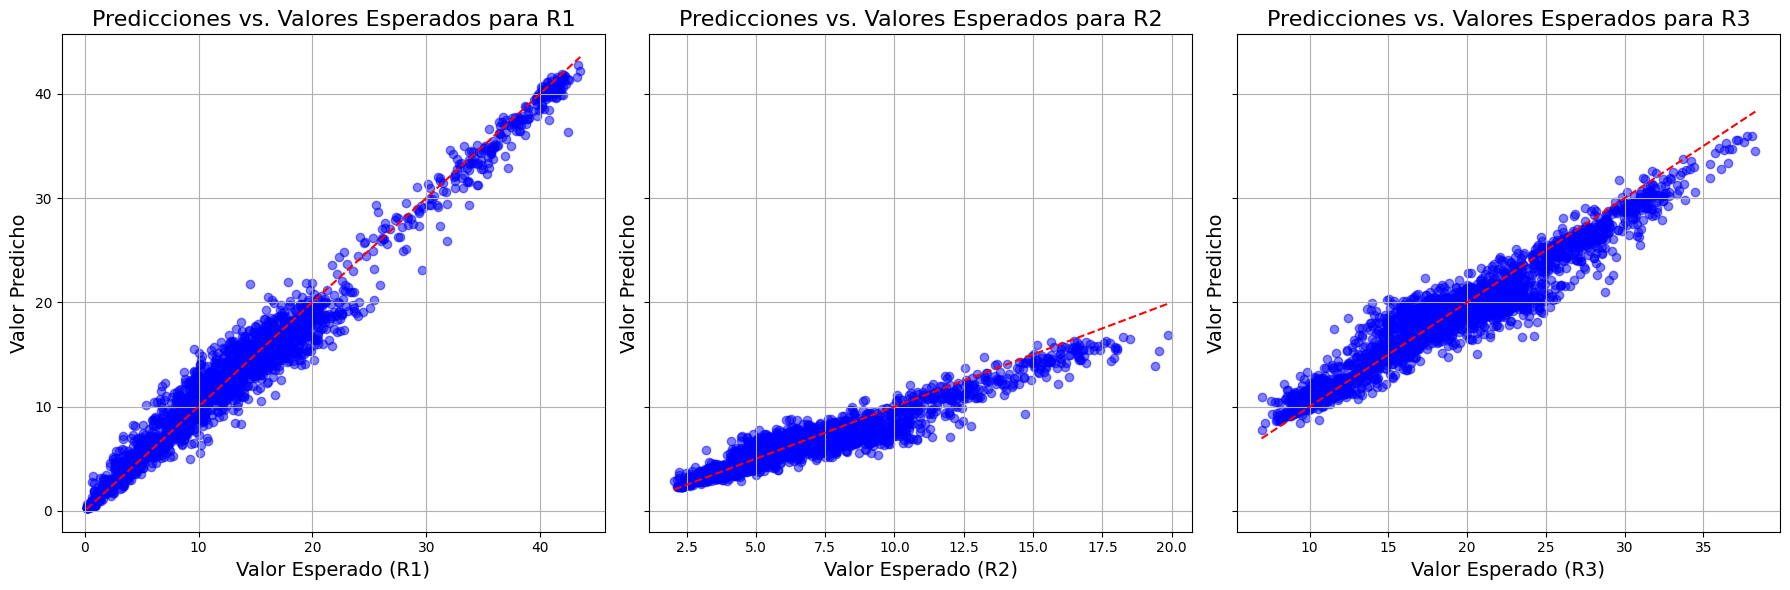

In [62]:
# Crear subgráficos
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Iterar sobre las columnas de predicción
for i, columna in enumerate(['R1', 'R2', 'R3']):
    # Scatter plot de los valores esperados vs. predichos para la columna actual
    axs[i].scatter(predicciones[columna], predicciones[f'P_{columna}'], color='blue', alpha=0.5)
    # Línea diagonal para referencia
    axs[i].plot([predicciones[columna].min(), predicciones[columna].max()], [predicciones[columna].min(), predicciones[columna].max()], color='red', linestyle='--')
    # Título y etiquetas de los ejes
    axs[i].set_title(f'Predicciones vs. Valores Esperados para {columna}', fontsize=16)
    axs[i].set_xlabel(f'Valor Esperado ({columna})', fontsize=14)
    axs[i].set_ylabel('Valor Predicho', fontsize=14)
    # Cuadrícula
    axs[i].grid(True)

# Mostrar el gráfico
plt.tight_layout()
plt.show()

# Import / Export de Modelos

TensorFlow

In [ ]:
model.save('mlp_model')

In [ ]:
loaded_model = tf.keras.models.load_model('mlp_model')

Pickle

In [ ]:
mlp.save('mlp_model.h5')
with open('mlp_model_pickle.pkl', 'wb') as file:
    pickle.dump('mlp_model.h5', file)

In [ ]:
with open('mlp_model_pickle.pkl', 'rb') as file:
    model_file = pickle.load(file)
loaded_model = tf.keras.models.load_model(model_file)

Joblib

In [ ]:
joblib.dump(mlp, 'mlp_regressor_model.pkl')

['mlp_regressor_model.pkl']

In [ ]:
mlp_loaded = joblib.load('mlp_regressor_model.pkl')